<a href="https://colab.research.google.com/github/mohmiim/MLIntroduction/blob/master/session-6/Adv_MultiVarMultiStep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 2.x
import tensorflow as tf

TensorFlow 2.x selected.


In [2]:
import os

!wget --no-check-certificate \
    https://raw.githubusercontent.com/mohmiim/MLIntroduction/master/session-6/data/combined_csv.csv \
    -O /tmp/weather.csv

--2020-02-11 03:37:10--  https://raw.githubusercontent.com/mohmiim/MLIntroduction/master/session-6/data/combined_csv.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 36442977 (35M) [text/plain]
Saving to: ‘/tmp/weather.csv’

/tmp/weather.csv    100%[===================>]  34.75M   179MB/s    in 0.2s    

2020-02-11 03:37:11 (179 MB/s) - ‘/tmp/weather.csv’ saved [36442977/36442977]



In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import csv
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Conv1D,Dense,MaxPooling1D,Flatten, Conv1D, Dropout,TimeDistributed, ConvLSTM2D,RepeatVector
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import Huber
from math import sqrt

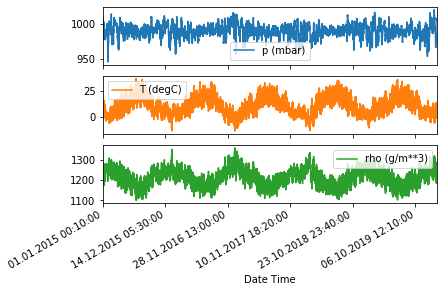

267783
260000
7783
[ 989.99427458   10.46017931 1212.53332065]
[ 8.70687271  8.23557779 39.21867288]


In [4]:
df = pd.read_csv("/tmp/weather.csv")


columnsToConsider = ['p (mbar)', 'T (degC)', 'rho (g/m**3)']
features = df[columnsToConsider]
features.index = df['Date Time']


features.plot(subplots=True)
plt.show()

TRAIN_DATA_SIZE = 260000

dataset = features.values

data_mean = dataset[:TRAIN_DATA_SIZE].mean(axis=0)
data_std = dataset[:TRAIN_DATA_SIZE].std(axis=0)

dataset = (dataset-data_mean)/data_std

print(len(dataset))

training_data = dataset[:TRAIN_DATA_SIZE]
validation_data = dataset[TRAIN_DATA_SIZE:]

print(len(training_data))
print(len(validation_data))

print(data_mean)
print(data_std)


In [0]:
def sequenceData(dataset, target, start_index, end_index, history_size,target_size, step, single_step=False):
    X = []
    y = []
    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size
    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        X.append(dataset[indices])
        if single_step:
            y.append(target[i+target_size])
        else:
            y.append(target[i:i+target_size])
    return np.array(X), np.array(y)


In [0]:
LOOK_AHEAD = 72
STEP = 6
WINDOW_SIZE = 720
BATCH_SIZE = 256
BUFFER_SIZE = 1000
SEQ = 5
N_LENGTH = int((WINDOW_SIZE/STEP)/SEQ)
CONVLSTM = True

In [7]:
X_train, y_train = sequenceData(dataset, dataset[:, 1], 0,
                                 TRAIN_DATA_SIZE, WINDOW_SIZE,
                                 LOOK_AHEAD, STEP)

X_val, y_val = sequenceData(dataset, dataset[:, 1],
                            TRAIN_DATA_SIZE, None, WINDOW_SIZE,
                            LOOK_AHEAD, STEP)

print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(259280, 120, 3)
(259280, 72)
(6991, 120, 3)
(6991, 72)


In [8]:
if CONVLSTM:
    print(X_train.shape)
    X_train = X_train.reshape(X_train.shape[0],SEQ,1,N_LENGTH,X_train.shape[2])
    X_val = X_val.reshape(X_val.shape[0],SEQ,1,N_LENGTH,X_val.shape[2])
    print(X_train.shape)

train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_data = train_data.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

val_data = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_data = val_data.batch(BATCH_SIZE)

(259280, 120, 3)
(259280, 5, 1, 24, 3)


In [0]:
def create_time_steps(length):
    return list(range(-length, 0))

In [0]:
def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(12, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)
    plt.plot(num_in, np.array(history[:, 1]), label='History')
    plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
             label='True Future')
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
                 label='Predicted Future')
        plt.legend(loc='upper left')
    plt.show()

(5, 1, 24, 3)
(120, 3)


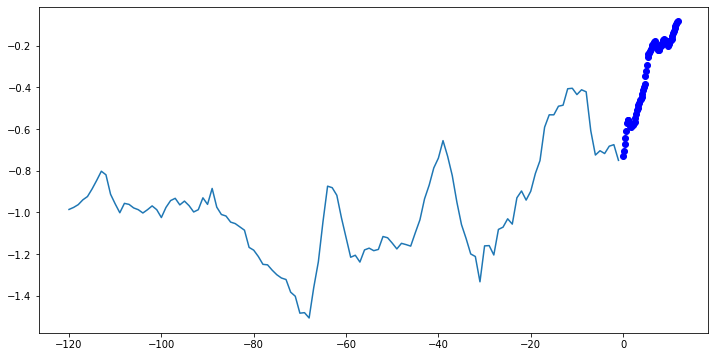

In [11]:
for x, y in train_data.take(1):
  if CONVLSTM :
    print(x[0].shape)
    x = x[0].numpy().reshape(SEQ*N_LENGTH,x.shape[4])
    print(x.shape)
    multi_step_plot(x, y[0], np.array([0]))
  else:
    multi_step_plot(x[0], y[0], np.array([0]))

In [0]:
def createConv_LSTMModel() :
  model = Sequential()
  model.add(Conv1D(512, 5, activation='relu', input_shape=X_train.shape[-2:]))
  model.add(Conv1D(512, 5, activation='relu'))
  model.add(MaxPooling1D())
  model.add(LSTM(144,return_sequences=True,activation='relu'))
  model.add(LSTM(72, activation='relu'))
  model.add(Dense(72))
  model.compile(optimizer=tf.keras.optimizers.Adam(), loss='mae')
  return model

In [0]:
def createConvLSTM() :
    model = Sequential()
    print(X_train.shape[2])
    model.add(ConvLSTM2D(64, (1,3), activation='relu', input_shape=(SEQ, 1, N_LENGTH, X_train.shape[4]))) 
    model.add(Flatten())
    model.add(RepeatVector(72))
    model.add(LSTM(200, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(100, activation='relu')))
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss='mse', optimizer='adam')
    return model

In [0]:
def createLSTMModel() :
  model = Sequential()
  model.add(LSTM(32,return_sequences=True,activation='relu',input_shape=X_train.shape[-2:]))
  model.add(LSTM(16, activation='relu'))
  model.add(Dense(72))
  model.compile(optimizer=tf.keras.optimizers.Adam(), loss='mae')
  return model

In [15]:
if CONVLSTM:    
    model  = createConvLSTM()
else:
    model = createLSTMModel()
    
model.summary()


1
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d (ConvLSTM2D)    (None, 1, 22, 64)         51712     
_________________________________________________________________
flatten (Flatten)            (None, 1408)              0         
_________________________________________________________________
repeat_vector (RepeatVector) (None, 72, 1408)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 72, 200)           1287200   
_________________________________________________________________
time_distributed (TimeDistri (None, 72, 100)           20100     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 72, 1)             101       
Total params: 1,359,113
Trainable params: 1,359,113
Non-trainable params: 0
____________________________________________

In [0]:
EVALUATION_INTERVAL = 200
EPOCHS = 50

history = model.fit(train_data, epochs=EPOCHS)




Train for 1013 steps
Epoch 1/50
 721/1013 [====================>.........] - ETA: 34s - loss: 32.5876

In [0]:
for X, y in val_data.take(10):
    if CONVLSTM:
        multi_step_plot(X[0].numpy().reshape(SEQ*N_LENGTH,X.shape[4]), y[0], model.predict(X)[0])
    else :
        multi_step_plot(X[0], y[0], model.predict(X)[0])